<a href="https://colab.research.google.com/github/manyamule/WCEHackathon2025_Introspectors/blob/main/ARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install necessary libraries
!pip install statsmodels pandas numpy matplotlib seaborn scikit-learn

In [2]:
# Import all required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os
import warnings
warnings.filterwarnings('ignore')

# Libraries for ARIMA modeling
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

# Libraries for evaluation
from sklearn.metrics import mean_squared_error
import math
import joblib

# Create directories for saving outputs
os.makedirs('models', exist_ok=True)
os.makedirs('plots', exist_ok=True)
os.makedirs('reports', exist_ok=True)

print("Environment set up complete!")

Environment set up complete!


In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Load data from CSV with flexible date parsing
def load_data(csv_path):
    print(f"Loading data from: {csv_path}")

    # First, try to determine if the file is tab-separated or comma-separated
    with open(csv_path, 'r') as f:
        first_line = f.readline().strip()
        if '\t' in first_line:
            print("Detected tab-separated file")
            df = pd.read_csv(csv_path, sep='\t')
        else:
            print("Assuming comma-separated file")
            df = pd.read_csv(csv_path)

    print(f"Raw data shape: {df.shape}")
    print("Column names:", df.columns.tolist())
    print("\nFirst 3 rows of raw data:")
    print(df.head(3))

    # Convert datetime column to datetime type and set as index
    if 'dt_time' in df.columns:
        # Try to parse dates with pandas' flexible parser
        print("\nConverting dates to datetime format...")
        df['dt_time'] = pd.to_datetime(df['dt_time'], infer_datetime_format=True)
        df.set_index('dt_time', inplace=True)

    print(f"\nProcessed data shape: {df.shape}")
    print(f"Date range: {df.index.min()} to {df.index.max()}")

    # Check for missing values
    missing = df.isnull().sum()
    if missing.sum() > 0:
        print("\nMissing values per column:")
        print(missing[missing > 0])

    return df

# Load air quality data
data = load_data('/content/drive/MyDrive/WCE/air_quality_data.csv')

# Display first few rows of processed data
print("\nFirst 5 rows of processed data:")
data.head()

Mounted at /content/drive
Loading data from: /content/drive/MyDrive/WCE/air_quality_data.csv
Assuming comma-separated file
Raw data shape: (3356255, 4)
Column names: ['dt_time', 'pm2.5cnc', 'pm10cnc', 'deviceid']

First 3 rows of raw data:
               dt_time  pm2.5cnc  pm10cnc  deviceid
0  2023-12-29 00:00:00    170.58   260.87  site_104
1  2023-12-29 00:15:00    164.56   279.53  site_104
2  2023-12-29 00:30:00    186.15   296.75  site_104

Converting dates to datetime format...

Processed data shape: (3356255, 3)
Date range: 2023-12-29 00:00:00 to 2024-12-31 00:00:00

Missing values per column:
pm2.5cnc    568730
pm10cnc     577798
dtype: int64

First 5 rows of processed data:


,pm2.5cnc,pm10cnc,deviceid
dt_time,,,
2023-12-29 00:00:00,170.58,260.87,site_104
2023-12-29 00:15:00,164.56,279.53,site_104
2023-12-29 00:30:00,186.15,296.75,site_104
2023-12-29 00:45:00,205.22,318.59,site_104
2023-12-29 01:00:00,211.11,334.24,site_104


Starting data preprocessing...
Selecting parameters: ['pm2.5cnc', 'pm10cnc']
Handling 1146528 missing values
Resampling data to 1h
Preprocessed data shape: (8833, 2)


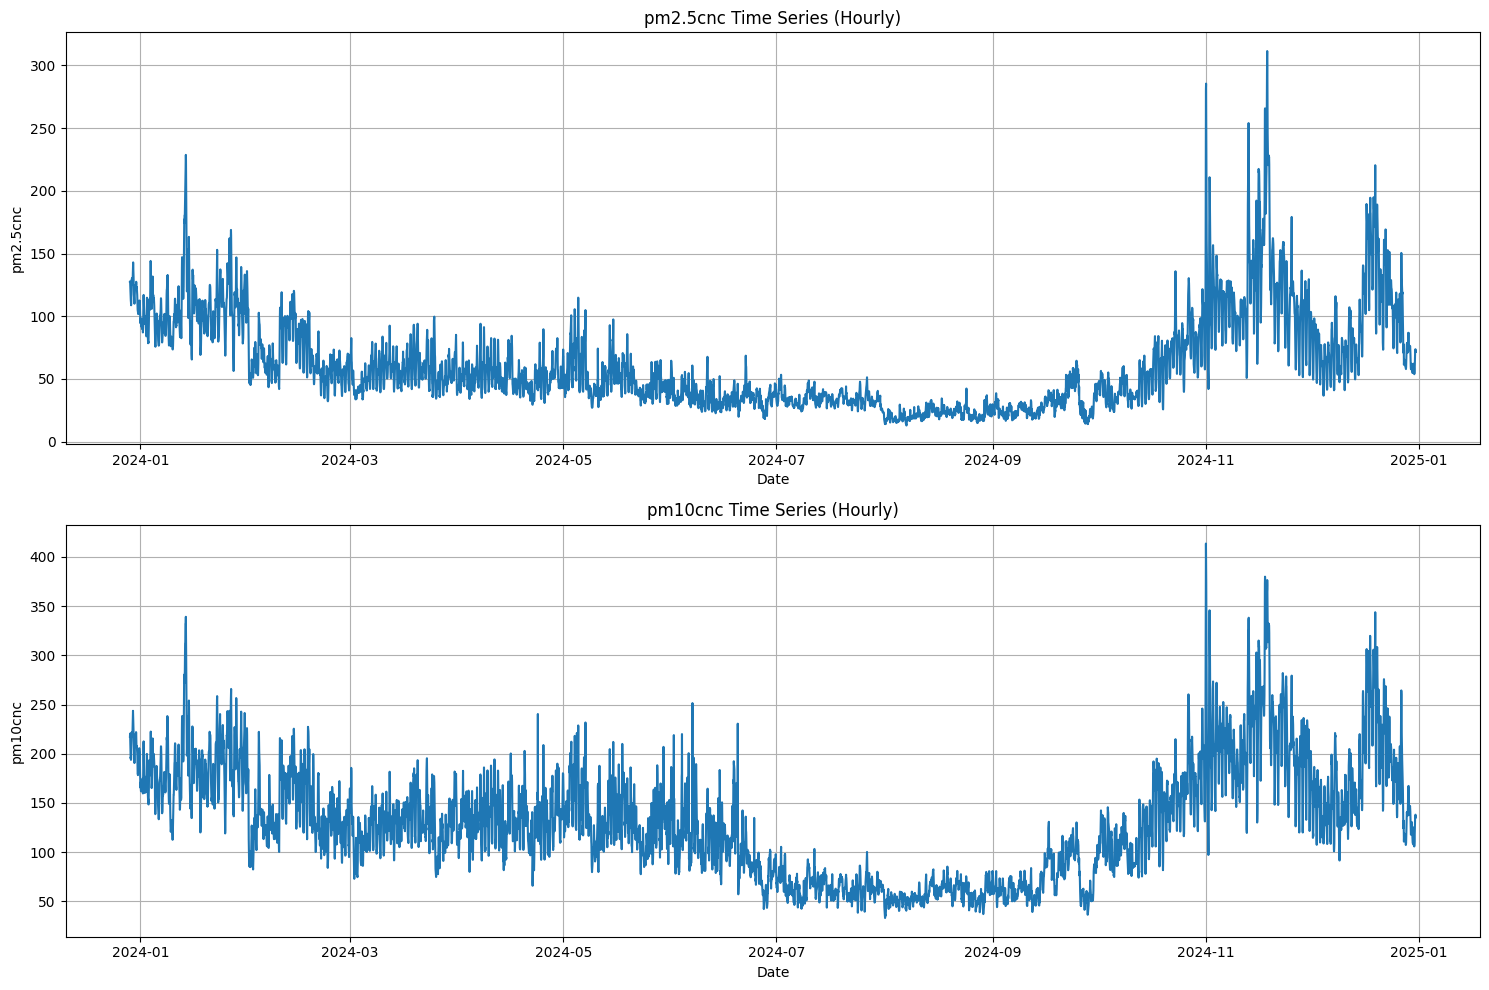


Preprocessed data (first 5 rows):


,pm2.5cnc,pm10cnc
dt_time,,
2023-12-29 00:00:00,127.568579,217.236579
2023-12-29 01:00:00,127.819000,220.494658
2023-12-29 02:00:00,124.464000,213.474184
2023-12-29 03:00:00,120.631447,208.380921
2023-12-29 04:00:00,117.210395,200.544342


In [4]:
def preprocess_data(df, params=None, resample=True, resample_freq='1h'):
    """
    Preprocess the air quality data:
    - Select specific parameters
    - Handle missing values
    - Resample to regular intervals
    """
    print("Starting data preprocessing...")

    # Select parameters if provided
    if params and all(param in df.columns for param in params):
        print(f"Selecting parameters: {params}")
        df = df[params]

    # Handle missing values
    if df.isnull().sum().sum() > 0:
        print(f"Handling {df.isnull().sum().sum()} missing values")
        df.ffill(inplace=True)  # Forward fill
        df.bfill(inplace=True)  # Backward fill

    # Resample data if needed
    if resample:
        print(f"Resampling data to {resample_freq}")
        df = df.resample(resample_freq).mean()
        df.ffill(inplace=True)
        df.bfill(inplace=True)

    print(f"Preprocessed data shape: {df.shape}")
    return df

# Define parameters to analyze
params = ['pm2.5cnc', 'pm10cnc']

# Preprocess the data
preprocessed_data = preprocess_data(
    data,
    params=params,
    resample=True,
    resample_freq='1h'
)

# Plot time series data for visual inspection
plt.figure(figsize=(15, 10))
for i, param in enumerate(params):
    plt.subplot(len(params), 1, i+1)
    plt.plot(preprocessed_data.index, preprocessed_data[param])
    plt.title(f'{param} Time Series (Hourly)')
    plt.xlabel('Date')
    plt.ylabel(param)
    plt.grid(True)

plt.tight_layout()
plt.savefig('plots/arima_timeseries_plot.png')
plt.show()

# Display preprocessed data
print("\nPreprocessed data (first 5 rows):")
preprocessed_data.head()


Checking stationarity for pm2.5cnc:
Results of Augmented Dickey-Fuller Test for pm2.5cnc:
Test Statistic                   -4.071759
p-value                           0.001078
#Lags Used                       36.000000
Number of Observations Used    8796.000000
Critical Value (1%)              -3.431094
Critical Value (5%)              -2.861869
Critical Value (10%)             -2.566945
dtype: float64
Is pm2.5cnc stationary? Yes


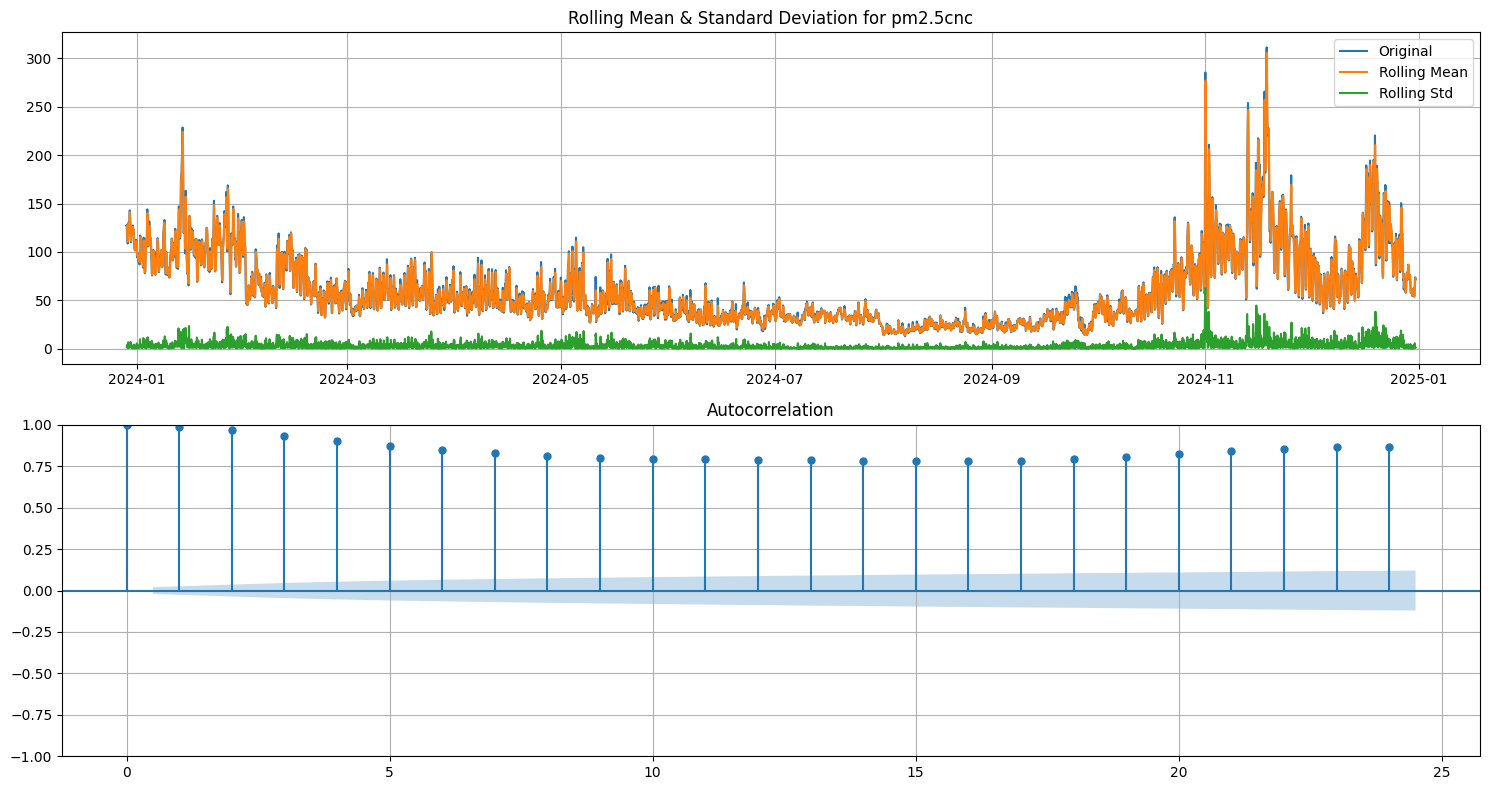

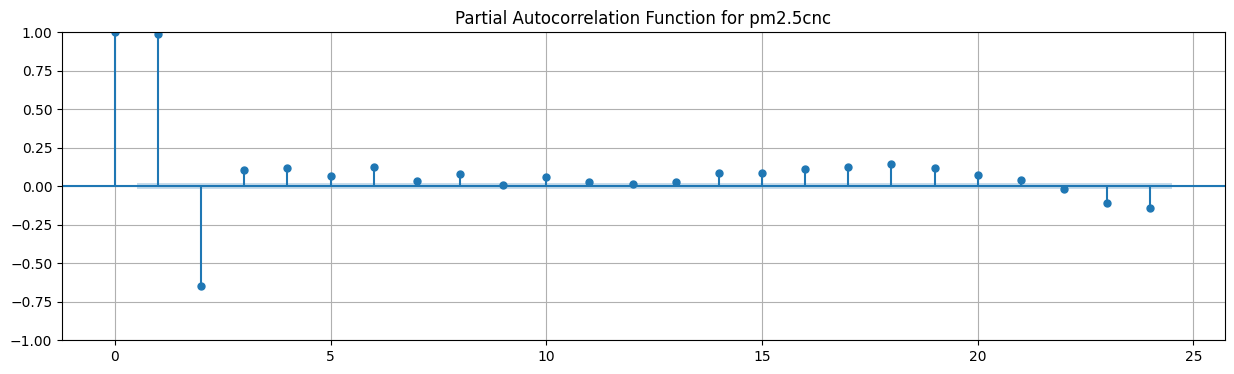


Checking stationarity for pm10cnc:
Results of Augmented Dickey-Fuller Test for pm10cnc:
Test Statistic                   -3.922523
p-value                           0.001875
#Lags Used                       32.000000
Number of Observations Used    8800.000000
Critical Value (1%)              -3.431093
Critical Value (5%)              -2.861868
Critical Value (10%)             -2.566945
dtype: float64
Is pm10cnc stationary? Yes


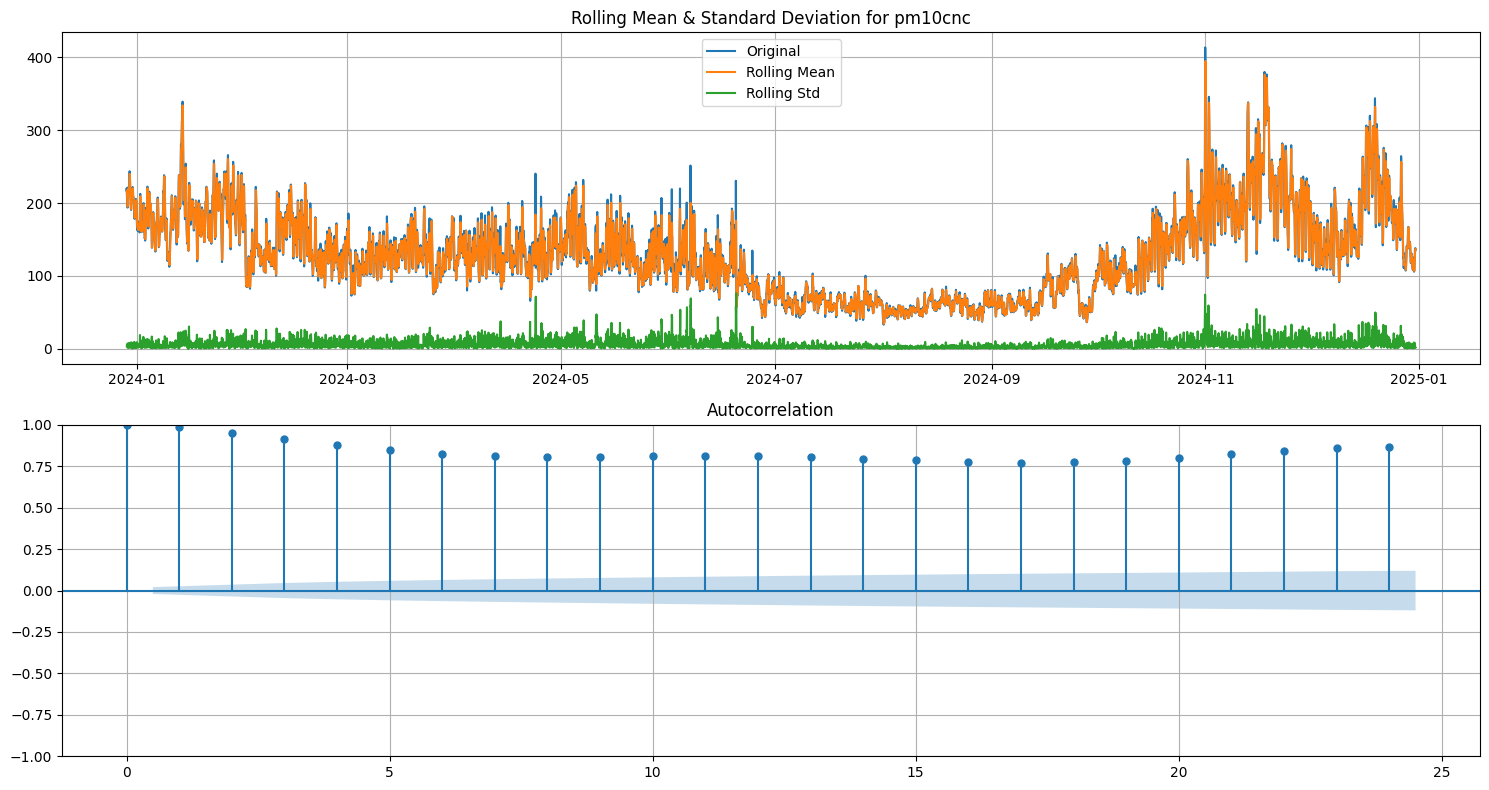

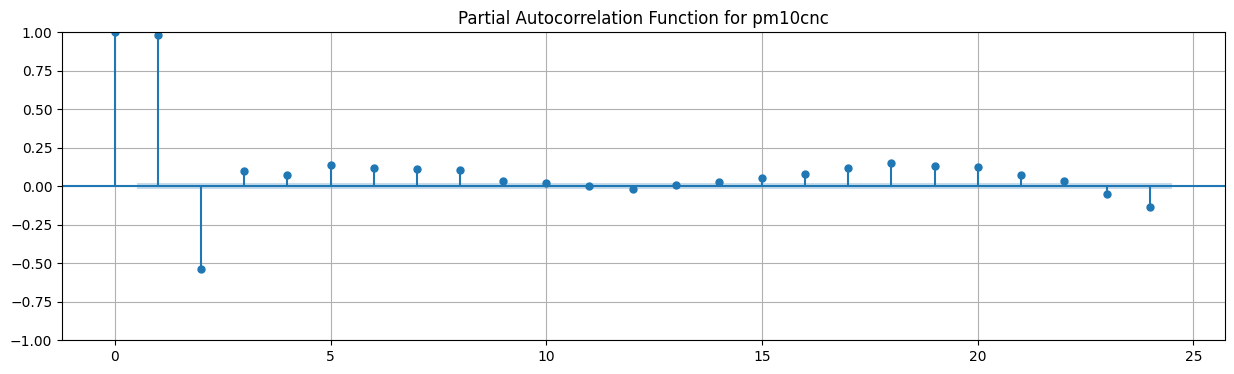


Stationarity Results Summary:
pm2.5cnc: Stationary (p-value: 0.0011)
pm10cnc: Stationary (p-value: 0.0019)


In [5]:
def check_stationarity(timeseries, param_name):
    """
    Check if a time series is stationary using the Augmented Dickey-Fuller test.
    Plot the time series, rolling mean, and rolling standard deviation.

    Args:
        timeseries: The time series to check
        param_name: Name of the parameter for plotting

    Returns:
        is_stationary: Boolean indicating if the series is stationary
        p_value: p-value from the ADF test
    """
    # Calculate rolling statistics
    rolling_mean = timeseries.rolling(window=3).mean()
    rolling_std = timeseries.rolling(window=3).std()

    # Plot rolling statistics
    plt.figure(figsize=(15, 8))
    plt.subplot(211)
    plt.plot(timeseries, label='Original')
    plt.plot(rolling_mean, label='Rolling Mean')
    plt.plot(rolling_std, label='Rolling Std')
    plt.legend(loc='best')
    plt.title(f'Rolling Mean & Standard Deviation for {param_name}')
    plt.grid(True)

    # Perform Augmented Dickey-Fuller test
    print(f'Results of Augmented Dickey-Fuller Test for {param_name}:')
    adf_test = adfuller(timeseries.dropna())
    adf_output = pd.Series(adf_test[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])

    for key, value in adf_test[4].items():
        adf_output[f'Critical Value ({key})'] = value

    print(adf_output)

    # Determine if stationary based on p-value
    is_stationary = adf_test[1] <= 0.05
    print(f"Is {param_name} stationary? {'Yes' if is_stationary else 'No'}")

    # Plot ACF and PACF
    plt.subplot(212)
    plot_acf(timeseries.dropna(), ax=plt.gca(), lags=24)
    plt.grid(True)

    plt.tight_layout()
    plt.savefig(f'plots/arima_stationarity_{param_name}.png')
    plt.show()

    # PACF in separate plot
    plt.figure(figsize=(15, 4))
    plot_pacf(timeseries.dropna(), ax=plt.gca(), lags=24)
    plt.grid(True)
    plt.title(f'Partial Autocorrelation Function for {param_name}')
    plt.savefig(f'plots/arima_pacf_{param_name}.png')
    plt.show()

    return is_stationary, adf_test[1]

# Check stationarity for each parameter
stationarity_results = {}
for param in params:
    print(f"\nChecking stationarity for {param}:")
    is_stationary, p_value = check_stationarity(preprocessed_data[param], param)
    stationarity_results[param] = {
        'is_stationary': is_stationary,
        'p_value': p_value
    }

print("\nStationarity Results Summary:")
for param, result in stationarity_results.items():
    print(f"{param}: {'Stationary' if result['is_stationary'] else 'Non-stationary'} (p-value: {result['p_value']:.4f})")

In [6]:
def determine_arima_params(timeseries, param_name, max_p=5, max_d=2, max_q=5):
    """
    Determine the best ARIMA parameters (p,d,q) based on AIC.

    Args:
        timeseries: The time series data
        param_name: Name of the parameter
        max_p: Maximum value for p (AR order)
        max_d: Maximum value for d (differencing)
        max_q: Maximum value for q (MA order)

    Returns:
        best_p, best_d, best_q: Best parameters
        best_aic: AIC value for the best model
    """
    print(f"Determining best ARIMA parameters for {param_name}...")
    best_aic = float("inf")
    best_params = None

    # Use a simplified grid search for this demonstration
    # For a full implementation, we would test all combinations of p, d, q

    # First, determine d (differencing) based on stationarity
    # If already stationary, d=0, otherwise d=1
    d = 0 if stationarity_results[param_name]['is_stationary'] else 1

    # Test some common combinations of p and q
    param_combinations = [
        (1, d, 1),
        (1, d, 2),
        (2, d, 1),
        (2, d, 2),
        (0, d, 1),
        (1, d, 0)
    ]

    for params in param_combinations:
        p, d, q = params
        try:
            # Fit ARIMA model
            model = ARIMA(timeseries, order=(p, d, q))
            model_fit = model.fit()

            # Get AIC
            aic = model_fit.aic

            print(f"ARIMA({p},{d},{q}) - AIC: {aic:.4f}")

            # Update best parameters if current model has better AIC
            if aic < best_aic:
                best_aic = aic
                best_params = (p, d, q)
        except:
            print(f"Error fitting ARIMA({p},{d},{q})")
            continue

    if best_params:
        best_p, best_d, best_q = best_params
        print(f"Best ARIMA parameters for {param_name}: ({best_p},{best_d},{best_q}) with AIC: {best_aic:.4f}")
        return best_p, best_d, best_q, best_aic
    else:
        print(f"Could not determine best parameters for {param_name}. Using default (1,1,1)")
        return 1, 1, 1, float("inf")

def fit_arima_model(timeseries, param_name, order):
    """
    Fit ARIMA model with the specified order.

    Args:
        timeseries: The time series data
        param_name: Name of the parameter
        order: ARIMA order (p,d,q)

    Returns:
        model_fit: Fitted ARIMA model
    """
    p, d, q = order
    print(f"Fitting ARIMA({p},{d},{q}) model for {param_name}...")

    # Fit the model
    model = ARIMA(timeseries, order=(p, d, q))
    model_fit = model.fit()

    # Print model summary
    print("\nModel Summary:")
    print(model_fit.summary().tables[0])
    print(model_fit.summary().tables[1])

    return model_fit

# Determine best parameters and fit ARIMA models for each parameter
arima_models = {}
for param in params:
    print(f"\n{'='*50}")
    print(f"ARIMA Modeling for {param}")
    print(f"{'='*50}")

    # Determine best parameters
    best_p, best_d, best_q, best_aic = determine_arima_params(preprocessed_data[param], param)

    # Fit model with best parameters
    model_fit = fit_arima_model(preprocessed_data[param], param, (best_p, best_d, best_q))

    # Save model
    arima_models[param] = {
        'model': model_fit,
        'order': (best_p, best_d, best_q),
        'aic': best_aic
    }

    # Save model to disk
    joblib.dump(model_fit, f'models/arima_{param}.joblib')
    print(f"Model saved to 'models/arima_{param}.joblib'")

print("\nARIMA models fitted and saved successfully!")


ARIMA Modeling for pm2.5cnc
Determining best ARIMA parameters for pm2.5cnc...
ARIMA(1,0,1) - AIC: 50920.0991
ARIMA(1,0,2) - AIC: 49699.0545
ARIMA(2,0,1) - AIC: 49515.5117
ARIMA(2,0,2) - AIC: 49428.7795
ARIMA(0,0,1) - AIC: 77703.2996
ARIMA(1,0,0) - AIC: 54593.5310
Best ARIMA parameters for pm2.5cnc: (2,0,2) with AIC: 49428.7795
Fitting ARIMA(2,0,2) model for pm2.5cnc...

Model Summary:
                               SARIMAX Results                                
Dep. Variable:               pm2.5cnc   No. Observations:                 8833
Model:                 ARIMA(2, 0, 2)   Log Likelihood              -24708.390
Date:                Fri, 14 Mar 2025   AIC                          49428.779
Time:                        18:53:44   BIC                          49471.297
Sample:                    12-29-2023   HQIC                         49443.261
                         - 12-31-2024                                         
Covariance Type:                  opg                     

In [7]:
def detect_anomalies_arima(model, timeseries, param_name, threshold_sigmas=3):
    """
    Detect anomalies using the ARIMA model by comparing actual values with predictions.

    Args:
        model: Fitted ARIMA model
        timeseries: Original time series data
        param_name: Name of the parameter
        threshold_sigmas: Number of standard deviations to use as threshold

    Returns:
        DataFrame with anomaly detection results
    """
    print(f"\nDetecting anomalies for {param_name} using ARIMA...")

    # Generate predictions (fitted values)
    predictions = model.fittedvalues

    # Calculate residuals (actual - predicted)
    residuals = timeseries - predictions

    # Calculate statistics for residuals
    residual_mean = residuals.mean()
    residual_std = residuals.std()

    print(f"Residual statistics - Mean: {residual_mean:.4f}, Std: {residual_std:.4f}")

    # Define thresholds for anomalies
    upper_threshold = residual_mean + threshold_sigmas * residual_std
    lower_threshold = residual_mean - threshold_sigmas * residual_std

    print(f"Anomaly thresholds - Lower: {lower_threshold:.4f}, Upper: {upper_threshold:.4f}")

    # Create results DataFrame
    results = pd.DataFrame(index=timeseries.index)
    results['actual'] = timeseries
    results['predicted'] = predictions
    results['residual'] = residuals
    results['upper_threshold'] = upper_threshold
    results['lower_threshold'] = lower_threshold

    # Flag anomalies
    results['anomaly'] = (residuals > upper_threshold) | (residuals < lower_threshold)

    # Calculate anomaly metrics
    anomaly_count = results['anomaly'].sum()
    total_points = len(results)
    anomaly_percent = (anomaly_count / total_points) * 100

    print(f"Detected {anomaly_count} anomalies out of {total_points} points ({anomaly_percent:.2f}%)")

    # Calculate mean squared error
    mse = mean_squared_error(timeseries.dropna(), predictions.dropna())
    rmse = math.sqrt(mse)
    print(f"Model performance - MSE: {mse:.4f}, RMSE: {rmse:.4f}")

    return results

# Detect anomalies for each parameter
anomaly_results = {}
for param in params:
    model = arima_models[param]['model']
    results = detect_anomalies_arima(model, preprocessed_data[param], param)
    anomaly_results[param] = results

    # Save results to CSV
    results.to_csv(f'reports/arima_anomalies_{param}.csv')
    print(f"Anomaly detection results saved to 'reports/arima_anomalies_{param}.csv'")


Detecting anomalies for pm2.5cnc using ARIMA...
Residual statistics - Mean: 0.0049, Std: 4.0298
Anomaly thresholds - Lower: -12.0844, Upper: 12.0942
Detected 158 anomalies out of 8833 points (1.79%)
Model performance - MSE: 16.2372, RMSE: 4.0295
Anomaly detection results saved to 'reports/arima_anomalies_pm2.5cnc.csv'

Detecting anomalies for pm10cnc using ARIMA...
Residual statistics - Mean: 0.0051, Std: 8.3749
Anomaly thresholds - Lower: -25.1197, Upper: 25.1299
Detected 107 anomalies out of 8833 points (1.21%)
Model performance - MSE: 70.1315, RMSE: 8.3745
Anomaly detection results saved to 'reports/arima_anomalies_pm10cnc.csv'


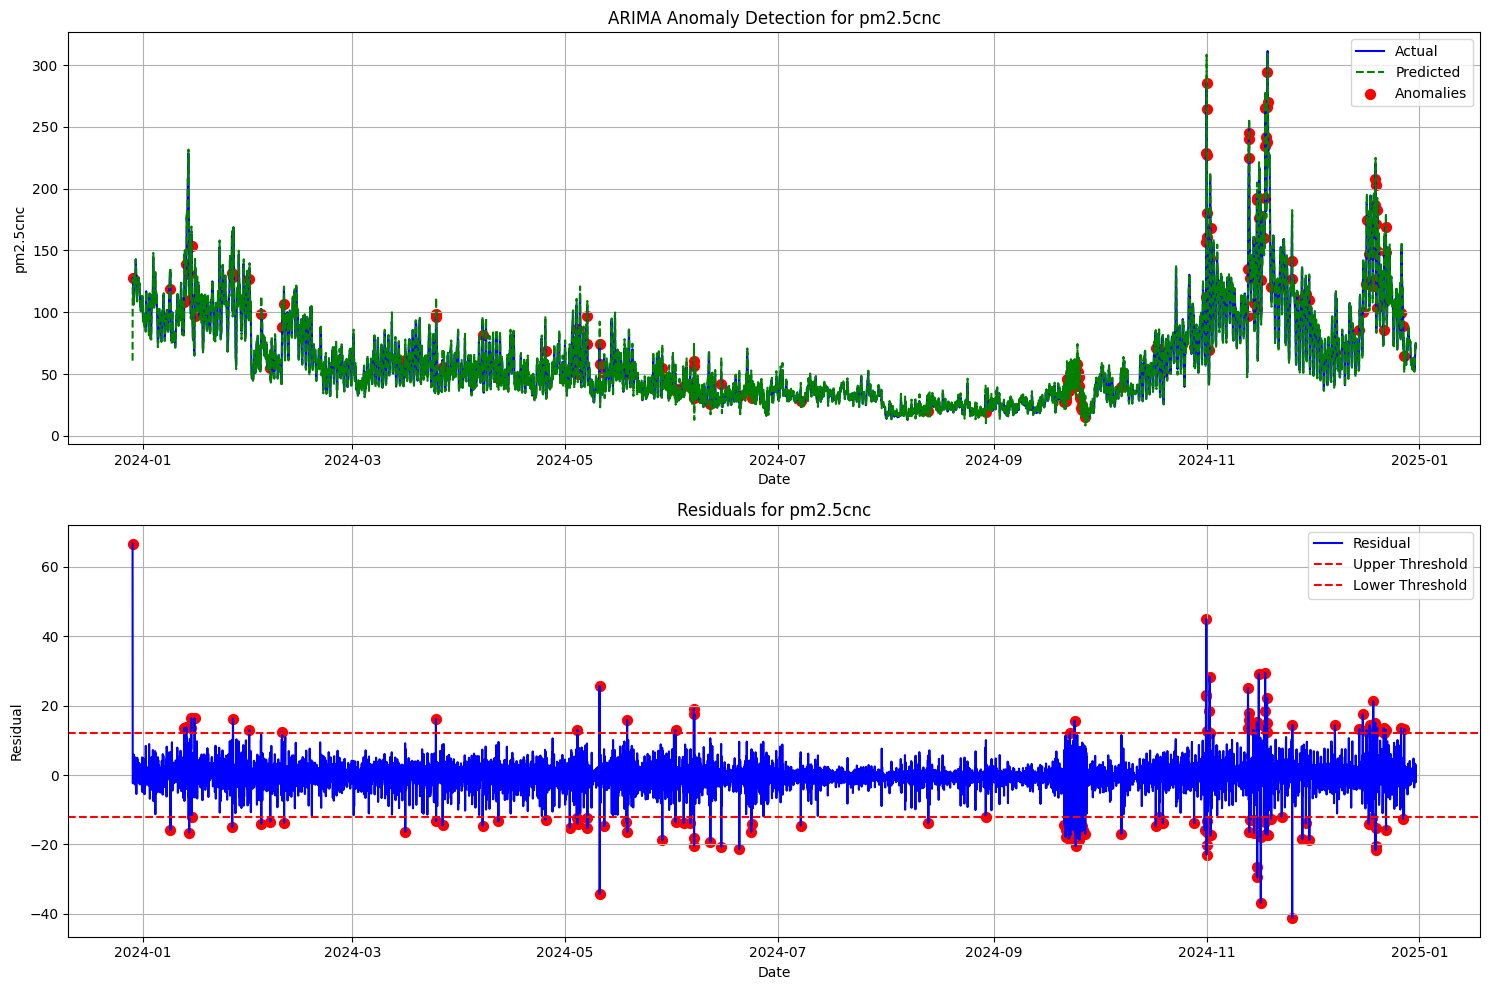

Anomaly plot for pm2.5cnc saved to 'plots/arima_anomalies_pm2.5cnc.png'


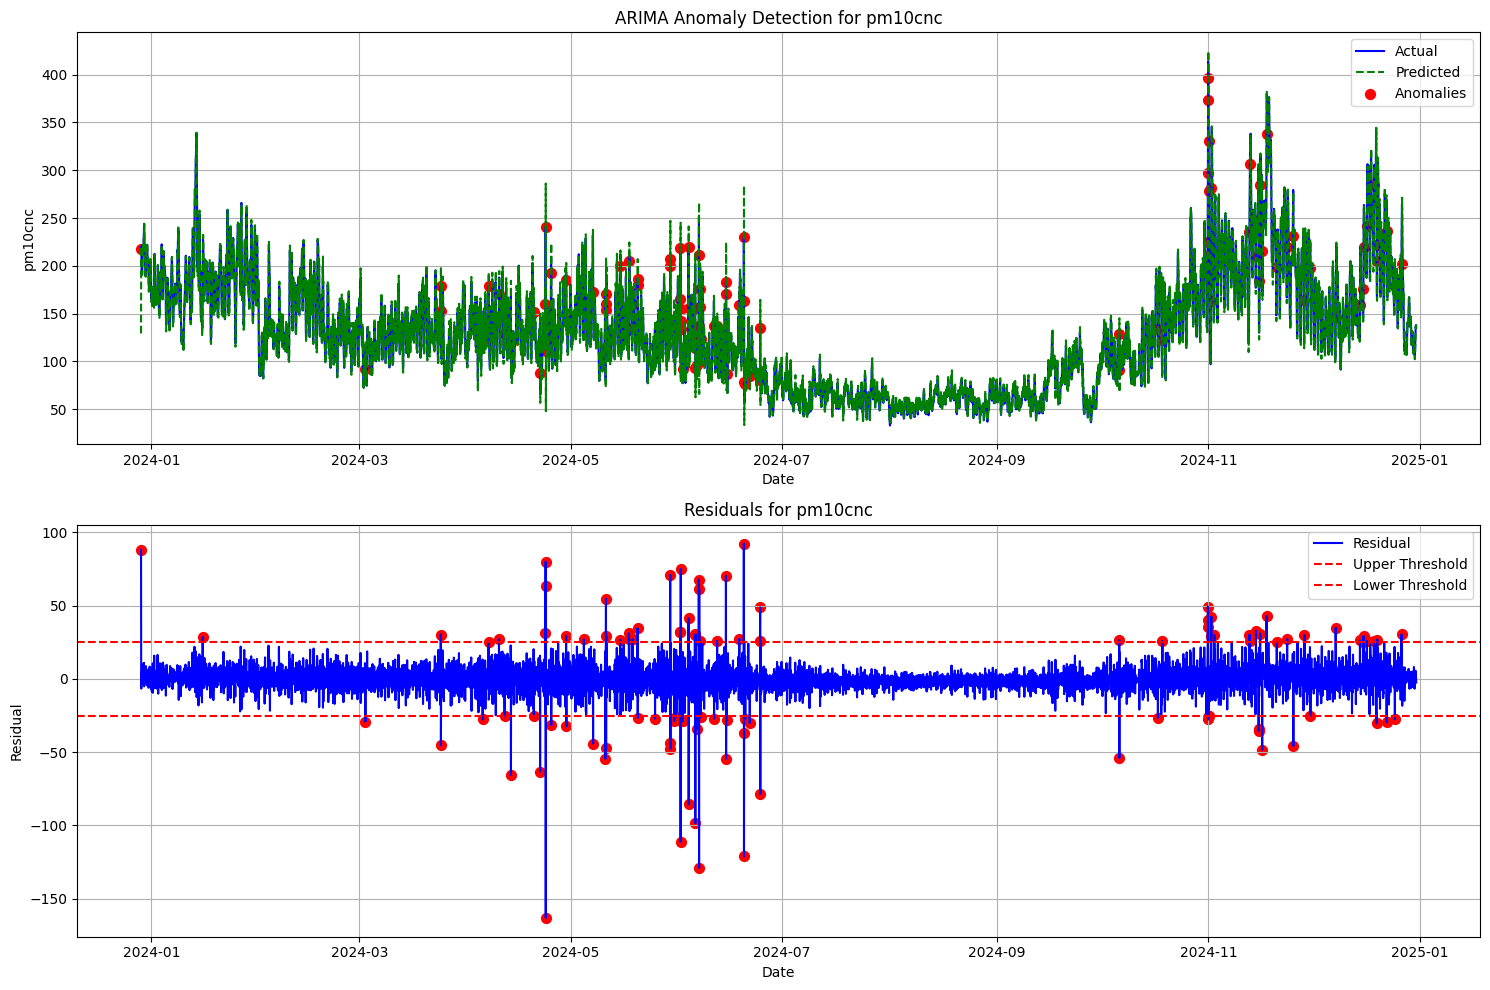

Anomaly plot for pm10cnc saved to 'plots/arima_anomalies_pm10cnc.png'


In [8]:
def plot_arima_anomalies(results, param_name):
    """
    Plot the original time series, predictions, and anomalies.

    Args:
        results: DataFrame with anomaly detection results
        param_name: Name of the parameter
    """
    plt.figure(figsize=(15, 10))

    # Plot 1: Original vs Predicted values
    plt.subplot(211)
    plt.plot(results.index, results['actual'], label='Actual', color='blue')
    plt.plot(results.index, results['predicted'], label='Predicted', color='green', linestyle='--')

    # Highlight anomalies
    anomalies = results[results['anomaly']]
    if not anomalies.empty:
        plt.scatter(anomalies.index, anomalies['actual'], color='red', s=50, label='Anomalies')

    plt.title(f'ARIMA Anomaly Detection for {param_name}')
    plt.xlabel('Date')
    plt.ylabel(param_name)
    plt.legend()
    plt.grid(True)

    # Plot 2: Residuals with threshold bands
    plt.subplot(212)
    plt.plot(results.index, results['residual'], label='Residual', color='blue')
    plt.axhline(y=results['upper_threshold'].iloc[0], color='red', linestyle='--', label='Upper Threshold')
    plt.axhline(y=results['lower_threshold'].iloc[0], color='red', linestyle='--', label='Lower Threshold')

    # Highlight anomalies in residual plot
    if not anomalies.empty:
        plt.scatter(anomalies.index, anomalies['residual'], color='red', s=50)

    plt.title(f'Residuals for {param_name}')
    plt.xlabel('Date')
    plt.ylabel('Residual')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig(f'plots/arima_anomalies_{param_name}.png')
    plt.show()

# Plot anomaly detection results for each parameter
for param in params:
    plot_arima_anomalies(anomaly_results[param], param)
    print(f"Anomaly plot for {param} saved to 'plots/arima_anomalies_{param}.png'")

In [9]:
# SAVE ARIMA RESULTS TO GOOGLE DRIVE
# Mount Google Drive if not already mounted
from google.colab import drive
try:
    drive.mount('/content/drive')
except:
    print("Drive already mounted")

# Set up directory in Drive where ARIMA results will be saved
arima_dir = '/content/drive/MyDrive/WCE/arima_results'

# Local directories and files patterns for ARIMA
arima_files = {
    'models': ['arima_*.joblib'],
    'plots': ['arima_*.png'],
    'reports': ['arima_*.csv', 'arima_*.json']
}

import os
import shutil
import glob

# Create the main directory
os.makedirs(arima_dir, exist_ok=True)
print(f"Creating ARIMA results directory: {arima_dir}")

# Copy all ARIMA files from local directories to Drive
files_copied = 0

for dir_type, patterns in arima_files.items():
    # Create subdirectory in Drive
    drive_subdir = f"{arima_dir}/{dir_type}"
    os.makedirs(drive_subdir, exist_ok=True)

    # Copy files matching each pattern
    for pattern in patterns:
        local_paths = glob.glob(f"{dir_type}/{pattern}")

        if local_paths:
            print(f"\nCopying files matching '{dir_type}/{pattern}':")

            # Copy each file
            for local_path in local_paths:
                filename = os.path.basename(local_path)
                drive_path = os.path.join(drive_subdir, filename)

                if os.path.isfile(local_path):
                    shutil.copy2(local_path, drive_path)
                    print(f"  - Copied: {filename}")
                    files_copied += 1
        else:
            print(f"\nNo files found matching '{dir_type}/{pattern}'")

print(f"\nSaved a total of {files_copied} ARIMA files to Google Drive at: {arima_dir}")

print("\nARIMA RESULTS SAVED SUCCESSFULLY!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Creating ARIMA results directory: /content/drive/MyDrive/WCE/arima_results

Copying files matching 'models/arima_*.joblib':
  - Copied: arima_pm2.5cnc.joblib
  - Copied: arima_pm10cnc.joblib

Copying files matching 'plots/arima_*.png':
  - Copied: arima_pacf_pm10cnc.png
  - Copied: arima_stationarity_pm2.5cnc.png
  - Copied: arima_pacf_pm2.5cnc.png
  - Copied: arima_anomalies_pm10cnc.png
  - Copied: arima_anomalies_pm2.5cnc.png
  - Copied: arima_timeseries_plot.png
  - Copied: arima_stationarity_pm10cnc.png

Copying files matching 'reports/arima_*.csv':
  - Copied: arima_anomalies_pm10cnc.csv
  - Copied: arima_anomalies_pm2.5cnc.csv

No files found matching 'reports/arima_*.json'

Saved a total of 11 ARIMA files to Google Drive at: /content/drive/MyDrive/WCE/arima_results

ARIMA RESULTS SAVED SUCCESSFULLY!


In [11]:
def generate_arima_summary(arima_models, anomaly_results, params):
    """
    Generate a comprehensive summary of ARIMA analysis.

    Args:
        arima_models: Dictionary of ARIMA models
        anomaly_results: Dictionary of anomaly detection results
        params: List of parameters analyzed
    """
    # Generate summary markdown
    summary = f"""
# ARIMA Anomaly Detection Summary

## Overview
ARIMA (AutoRegressive Integrated Moving Average) models were used to detect anomalies in air quality data. This approach detects anomalies by identifying data points that significantly deviate from the model's predictions.

## Model Parameters

"""

    for param in params:
        model_info = arima_models[param]
        p, d, q = model_info['order']

        # Get anomaly statistics
        results = anomaly_results[param]
        anomaly_count = results['anomaly'].sum()
        total_points = len(results)
        anomaly_percent = (anomaly_count / total_points) * 100

        # Calculate RMSE
        mse = mean_squared_error(results['actual'].dropna(), results['predicted'].dropna())
        rmse = math.sqrt(mse)

        summary += f"""
### {param}
- **ARIMA Order**: ({p},{d},{q})
- **AIC**: {model_info['aic']:.4f}
- **RMSE**: {rmse:.4f}
- **Anomalies Detected**: {anomaly_count} out of {total_points} ({anomaly_percent:.2f}%)
"""

    summary += """
## Advantages of ARIMA for Anomaly Detection

1. **Temporal Context**: ARIMA explicitly models time dependencies, making it suitable for time series data.
2. **Interpretability**: The model parameters and residuals provide insights into the data's behavior.
3. **Adaptability**: Different ARIMA configurations can be used based on the stationarity and autocorrelation patterns.
4. **Statistical Foundation**: Anomalies are detected based on statistical thresholds from prediction residuals.

## Limitations

1. **Stationarity Requirement**: ARIMA assumes stationarity, which may require data transformation.
2. **Parameter Selection**: Finding optimal (p,d,q) parameters can be challenging.
3. **Limited to Univariate Analysis**: Each parameter must be modeled separately.
4. **Data Volume**: Requires sufficient historical data for reliable parameter estimation.

## Recommendations

1. **Hybrid Approach**: Consider combining ARIMA with other methods like Isolation Forest for robust anomaly detection.
2. **Regular Retraining**: Update ARIMA models periodically as new data becomes available.
3. **Domain Validation**: Validate detected anomalies with domain experts to distinguish between statistical anomalies and meaningful events.
4. **Feature Engineering**: For non-stationary data, consider additional transformations or differencing.
"""

    # Save summary to a markdown file
    with open('reports/arima_summary.md', 'w') as f:
        f.write(summary)

    print("\nSummary generated and saved to 'reports/arima_summary.md'")
    return summary

# Generate ARIMA summary
print("Generating final summary report...")
summary = generate_arima_summary(arima_models, anomaly_results, params)

# Also save the summary to Drive
arima_dir = '/content/drive/MyDrive/WCE/arima_results'
summary_path = f"{arima_dir}/reports/arima_summary.md"
os.makedirs(os.path.dirname(summary_path), exist_ok=True)

with open(summary_path, 'w') as f:
    f.write(summary)
print(f"Summary also saved to Drive: {summary_path}")

print("\nARIMA ANALYSIS COMPLETE! All results have been saved to Google Drive.")

Generating final summary report...

Summary generated and saved to 'reports/arima_summary.md'
Summary also saved to Drive: /content/drive/MyDrive/WCE/arima_results/reports/arima_summary.md

ARIMA ANALYSIS COMPLETE! All results have been saved to Google Drive.
